In [ ]:
# Used at eval
import getpass
token = getpass.getpass(prompt="Enter your AstraDB token: ")
api_endpoint = input("Enter your AstraDB API endpoint: ")

Author: Devin Bost

This version includes tokenized raw and standardized addresses without geo information.



In [1]:
# Used at eval
import torch
print(torch.__version__)

2.2.1+cu121


In [ ]:
!git add /teamspace/studios/this_studio/experiments/T5_custom_tokenizer_v7_singapore.ipynb

In [ ]:
!git status

In [31]:
!git push -u origin master --force


Uploading LFS objects: 100% (1/1), 39 MB | 0 B/s, done.                         
Enumerating objects: 3, done.
Counting objects: 100% (3/3), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 371 bytes | 371.00 KiB/s, done.
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
remote: 
remote: Create a pull request for 'master' on GitHub by visiting:
remote:      https://github.com/devinbost/address_matcher/pull/new/master
remote: 
To https://github.com/devinbost/address_matcher.git
 * [new branch]      master -> master
branch 'master' set up to track 'origin/master'.


In [2]:
# Used at eval
%pip install transformers
import transformers

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Used at eval
%pip install astrapy
%pip install cassio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [53]:
eval_mode = True

In [4]:
import re
import random
import string

def expand_row(row):
    """
    Expands a single row into 10 by corrupting the ADDRESS 10 times, each time differently.
    """
    corruptions = [corrupt_address(row['ADDRESS']) for _ in range(10)]  # Unique corruption each time
    return pd.DataFrame({
        'CORRUPTED_ADDRESS': corruptions,
        'ADDRESS': [row['ADDRESS']] * 10
    })

def corrupt_address(address, corruption_level=1):
    """Randomly corrupts an address by changing some of its characters, excluding special tokens."""
    def random_char():
        chars = string.ascii_letters + string.digits + " ,.-"
        return random.choice(chars)

    def insert_random_chars(segment):
        insert_positions = random.sample(range(len(segment)), min(len(segment), corruption_level))
        for pos in insert_positions:
            segment = segment[:pos] + random_char() + segment[pos:]
        return segment

    def delete_random_chars(segment):
        if len(segment) > 1:
            delete_positions = random.sample(range(len(segment)), min(len(segment) - 1, corruption_level))
            for pos in sorted(delete_positions, reverse=True):
                segment = segment[:pos] + segment[pos+1:]
        return segment

    # Split the address into tokens and non-tokens
    tokens_and_non_tokens = re.split(r'(<[^>]+>)', address)
    corrupted_address_parts = []

    for part in tokens_and_non_tokens:
        if part.startswith('<') and part.endswith('>'):
            # This is a token, add it unchanged
            corrupted_address_parts.append(part)
        else:
            # This is a non-token, apply corruptions
            for _ in range(corruption_level):
                if len(part) > 1:
                    action = random.choice([insert_random_chars, delete_random_chars])
                    part = action(part)

            # Occasionally swap characters in non-token segments
            part_list = list(part)
            for _ in range(corruption_level // 2):
                if len(part_list) > 1:
                    char_pos = random.randrange(len(part_list) - 1)
                    part_list[char_pos], part_list[char_pos + 1] = part_list[char_pos + 1], part_list[char_pos]
            corrupted_address_parts.append(''.join(part_list))

    corrupted_address = ''.join(corrupted_address_parts)
    return corrupted_address

# Example usage of corrupting one address with this function
address = "<number>123</number> <street>Main St</street>, <city>Anytown</city>, <region>TX</region>, <postcode>78945</postcode>"
corrupted_address = corrupt_address(address, 1)
print(corrupted_address)


<number>j123</number> <street>MainSt</street>,E <city>Anytsown</city>,<region>TKX</region>,<postcode>7E8945</postcode>


In [3]:
# Used at eval
import requests
import zipfile
import os
import pandas as pd
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed

In [6]:


def process_csv_data(csv_path, ignore_empty=True):
    df = pd.read_csv(csv_path, dtype=str)

    # Filter out rows where STREET, DISTRICT, CITY, UNIT, and NUMBER are all empty
    df = df[(df['STREET'].notna() & df['STREET'].str.strip().ne('')) | 
            (df['DISTRICT'].notna() & df['DISTRICT'].str.strip().ne('')) | 
            (df['CITY'].notna() & df['CITY'].str.strip().ne('')) | 
            (df['UNIT'].notna() & df['UNIT'].str.strip().ne('')) | 
            (df['NUMBER'].notna() & df['NUMBER'].str.strip().ne(''))]

    # Select columns
    df = df[['LON', 'LAT', 'NUMBER', 'STREET', 'UNIT', 'CITY', 'DISTRICT', 'REGION', 'POSTCODE', 'ID', 'HASH']].fillna('') if ignore_empty else df

        # Construct ADDRESS more conditionally to avoid needing complex cleanup later
    def format_address(row):
        parts = [
            f"<number>{row['NUMBER']}</number>" if row['NUMBER'] else "",
            f"<street>{row['STREET']}</street>" if row['STREET'] else "",
            f"<unit>{row['UNIT']}</unit>" if row['UNIT'] else "",
            f"<city>{row['CITY']}</city>" if row['CITY'] else "",
            f"<district>{row['DISTRICT']}</district>" if row['DISTRICT'] else "",
            f"<region>{row['REGION']}</region>" if row['REGION'] else "",
            f"<postcode>{row['POSTCODE']}</postcode>" if row['POSTCODE'] else ""
        ]
        # Join non-empty parts with commas, strip leading/trailing commas and spaces
        return ', '.join(filter(None, parts)).strip(', ')

    df['ADDRESS'] = df.apply(format_address, axis=1)

    # Initialize a list to hold all expanded DataFrames
    expanded_rows_list = []
    print("second part starting")

    # # Iterate over each row in the DataFrame
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        expanded_rows = expand_row(row)
        expanded_rows_list.append(expanded_rows)
    #Using ProcessPoolExecutor with max_workers=8 and tqdm for progress tracking
    # with ProcessPoolExecutor(max_workers=8) as executor:
    #     futures = [executor.submit(expand_row, df.iloc[i]) for i in range(len(df))]
    #     for future in tqdm(as_completed(futures), total=len(futures)):
    #         expanded_rows_list.append(future.result())

    # Concatenate all expanded rows at once outside the loop
    expanded_df = pd.concat(expanded_rows_list, ignore_index=True)
    return expanded_df

def download_and_process_csv(url, extract_to_folder, output_file):
    os.makedirs(extract_to_folder, exist_ok=True)

    # Download the file
    r = requests.get(url)
    zip_path = os.path.join(extract_to_folder, 'downloaded.zip')

    # Save the downloaded zip file
    with open(zip_path, 'wb') as f:
        f.write(r.content)

    # Unzip the file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_folder)

    # Paths to the CSV files
    austin_csv_path = os.path.join(extract_to_folder, 'us/tx/austin.csv')
    singapore_csv_path = os.path.join(extract_to_folder, 'singapore/sg/countrywide.csv')

    # Process each CSV file into pandas DataFrames
    austin_df = process_csv_data(austin_csv_path, ignore_empty=True)
    print("first part done")
    singapore_df = process_csv_data(singapore_csv_path, ignore_empty=True)

    # Concatenate DataFrames and reset index
    final_df = pd.concat([austin_df, singapore_df]).reset_index(drop=True)

    # Write the DataFrame to a CSV file
    final_df.to_csv(output_file + ".csv", index=False)

    # write in parquet format
    parquet_file_path = output_file + '.parquet'
    final_df.to_parquet(parquet_file_path, engine='pyarrow')

    return final_df

# Example usage
url = 'https://data.openaddresses.io/runs/1198290/us/tx/austin.zip'
extract_to_folder = 'data'
output_file = "prepared_address_pairs-v7-singapore"
address_pairs = download_and_process_csv(url, extract_to_folder, output_file)
print(address_pairs)
# Takes about 2.5 min


second part starting


  0%|          | 0/15702 [00:00<?, ?it/s]

first part done
second part starting


  0%|          | 0/173332 [00:00<?, ?it/s]

                                         CORRUPTED_ADDRESS  \
0        <number> 11209</number> <street>ESHOFF RD</str...   
1        <number>1209</number> <street>EMHSHOFF RD</str...   
2        <number>112809</number> <street>qEMSHOFF RD</s...   
3        <number>112,09</number>,q <street>EMSHOFF R</s...   
4        <number>x11209</number>-, <street>EMSHOFF R</s...   
...                                                    ...   
1890335    <number>L19</number>,<street>GULX LANE</street>   
1890336  <number>B19</number>2, <street>GUL BLANE</street>   
1890337      <number>9</number> <street>UGUL LANE</street>   
1890338    <number>9</number>,l <street>GUL LAPNE</street>   
1890339    <number>9</number>,N <street>GUL LAN4E</street>   

                                                   ADDRESS  
0        <number>11209</number>, <street>EMSHOFF RD</st...  
1        <number>11209</number>, <street>EMSHOFF RD</st...  
2        <number>11209</number>, <street>EMSHOFF RD</st...  
3        <n

In [4]:
# Used at eval
pd.set_option('display.width', 480)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

In [9]:
# Used at eval
def read_corrupted_addresses(file_name):
    # Reads the CSV file into pandas DataFrame
    return pd.read_csv(file_name + '.csv')

# Now reading back the file to see the pairs
#address_pairs = read_corrupted_addresses("/teamspace/studios/this_studio/prepared_address_pairs-v7")
print(address_pairs.head())  # Just to print the first few rows as an example
print(address_pairs.tail())
# We only need to run this method if we're loading from a file instead of rebuilding a training set

                                                                                                                 CORRUPTED_ADDRESS                                                                                                                       ADDRESS
0  <number>1h1209</number> <street>EMfSHOFF RD</street>F, <city>BELVILLE</city>,<region>T6X</region>n, <postcode>774518</postcode>  <number>11209</number>, <street>EMSHOFF RD</street>, <city>BELLVILLE</city>, <region>TX</region>, <postcode>77418</postcode>
1        <number>1209</number> <street>EMySHOFF RD</street>,<city>BELLVLLE</city> <region>T</region>4, <postcode>n77418</postcode>  <number>11209</number>, <street>EMSHOFF RD</street>, <city>BELLVILLE</city>, <region>TX</region>, <postcode>77418</postcode>
2        <number>1209</number>,<street>ESHOFF RD</street>,K <city>BELLVILL</city> , <region>T</region> <postcode>717418</postcode>  <number>11209</number>, <street>EMSHOFF RD</street>, <city>BELLVILLE</city>, <region>TX</region>,

We model this mapping as a Sequence-to-sequence task and start with a transformer that has been pre-trained on denoising tasks.

The T5 model is one of these, and it was presented in this paper:
https://arxiv.org/pdf/1910.10683.pdf

The model documentation and source code is available here: https://huggingface.co/transformers/v3.0.2/model_doc/t5.html#overview

The premise of using a pretrained model as a base is that it simplifies the amount of training we need to do up-front to get a working model.

Update: We're using this specific version, UMT5: https://huggingface.co/docs/transformers/main/model_doc/umt5
Update2: Actually, we're now using ByT5... https://huggingface.co/docs/transformers/main/model_doc/byt5

In [4]:
# Used at eval
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import random
import numpy as np

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# If you are using CUDA (GPU), also set this for reproducibility
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

In [3]:
# # Used at eval
# # Assuming the necessary imports and AddressDataset definition are already provided

# # Split dataset
# train_pairs, temp_pairs = train_test_split(address_pairs, test_size=0.2, random_state=42)
# val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5, random_state=42)

# # Reset pandas indices so we don't get key errors:
# train_pairs = train_pairs.reset_index(drop=True)
# val_pairs = val_pairs.reset_index(drop=True)
# test_pairs = test_pairs.reset_index(drop=True)

NameError: name 'address_pairs' is not defined

In [5]:
# Used at eval
import sentencepiece
print(sentencepiece.__version__)

0.2.0


In [6]:
# Used at eval

special_address_tokens = [
    '<lat>', '</lat>', '<lon>', '</lon>',
    '<number>', '</number>', '<street>', '</street>',
    '<unit>', '</unit>', '<city>', '</city>',
    '<region>', '</region>', '<postcode>', '</postcode>',
    'St', 'St.', 'Street',
    'Ave', 'Ave.', 'Avenue',
    'Rd', 'Rd.', 'Road',
    'Ln', 'Ln.', 'Lane',
    'Dr', 'Dr.', 'Drive',
    'Blvd', 'Blvd.', 'Boulevard',
    'Ter', 'Ter.', 'Terrace',
    'Pl', 'Pl.', 'Place',
    'Ct', 'Ct.', 'Court',
    'Sq', 'Sq.', 'Square',
    'Pkwy', 'Pkwy.', 'Parkway',
    'Cir', 'Cir.', 'Circle',
    'Hwy', 'Hwy.', 'Highway',
    'Alley', 'Ally', 'Aly',
    'Junction', 'Jct', 'Jct.',
    'Expressway', 'Expy', 'Expy.',
    'Freeway', 'Fwy', 'Fwy.',
    'Trail', 'Trl', 'Trl.',
    'Path', 'Path.', 'Pth',
    'Roadway', 'Rdwy', 'Rdwy.',
    'Route', 'Rte', 'Rte.',
    'Stravenue', 'Stra', 'Stra.',
    'Loop', 'Lp', 'Lp.',
    'Pike', 'Pk', 'Pk.',
    'Apartment', 'Apt', 'Apt.',
    'Unit', 'Unit.', 'Unt',
    'Suite', 'Ste', 'Ste.',
    'Floor', 'Fl', 'Fl.',
    'Room', 'Rm', 'Rm.',
    'PO Box', 'P.O. Box', 'Box',
    'Building', 'Bldg', 'Bldg.',
    'Tower', 'Twr', 'Twr.',
    'Villa', 'Vl', 'Vl.',
    'Mansion', 'Mnsn', 'Mnsn.',
    'Dorm', 'Dormitory', 'Drm',
    'Condo', 'Condominium', 'Cndo',
    'Townhouse', 'Twnhse', 'Twnhs',
    '<NE>', '</NE>', '<NW>', '</NW>', '<SE>', '</SE>', '<SW>', '</SW>', # Directions
    'Northeast', 'Northwest', 'Southeast', 'Southwest',
    'North', 'N', 'South', 'S', 'East', 'E', 'West', 'W'
]

In [7]:
# Used at eval
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import lightning as pl
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

torch.set_float32_matmul_precision("medium")

vector_length = 512

class AddressDataset(Dataset):
    def __init__(self, tokenizer, corrupted_addresses, real_addresses, max_length=vector_length):
        self.tokenizer = tokenizer
        self.corrupted_addresses = corrupted_addresses
        self.real_addresses = real_addresses
        self.max_length = max_length

    def __len__(self):
        return len(self.corrupted_addresses)

    def __getitem__(self, idx):
        source = self.corrupted_addresses[idx]
        target = self.real_addresses[idx]

        source_tokenized = self.tokenizer.encode_plus(source, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        target_tokenized = self.tokenizer.encode_plus(target, max_length=self.max_length, padding='max_length', truncation=True, return_tensors='pt')
        
        source_ids = source_tokenized['input_ids'].squeeze()
        attention_mask = source_ids.ne(self.tokenizer.pad_token_id)
        target_ids = target_tokenized['input_ids'].squeeze()

        return {"source_ids": source_ids, "attention_mask": attention_mask, "target_ids": target_ids}

class AddressDataModule(pl.LightningDataModule):
    def __init__(self, tokenizer, batch_size=2, max_length=vector_length, data_file='/teamspace/studios/this_studio/prepared_address_pairs-v7-singapore.parquet'):
        super().__init__()
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length
        self.data_file = data_file

    def setup(self, stage=None):
        # Load the dataset
        df = pd.read_parquet(self.data_file)
        
        # Use the "CORRUPTED_ADDRESS" and "ADDRESS" columns
        corrupted_addresses = df['CORRUPTED_ADDRESS'].tolist()
        real_addresses = df['ADDRESS'].tolist()
        
        # Split data into training, validation, and test sets
        train_corrupted, test_corrupted, train_real, test_real = train_test_split(corrupted_addresses, real_addresses, test_size=0.2)
        train_corrupted, val_corrupted, train_real, val_real = train_test_split(train_corrupted, train_real, test_size=0.25)  # 0.25 x 0.8 = 0.2
        
        # Assign dataset instances for each split
        self.train_dataset = AddressDataset(self.tokenizer, train_corrupted, train_real, self.max_length)
        self.val_dataset = AddressDataset(self.tokenizer, val_corrupted, val_real, self.max_length)
        self.test_dataset = AddressDataset(self.tokenizer, test_corrupted, test_real, self.max_length)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=7)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=7)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=7)


class AddressModel(pl.LightningModule):
    def __init__(self, tokenizer, special_tokens, learning_rate=3e-5):
        super().__init__()
        self.tokenizer = tokenizer
        self.learning_rate = learning_rate
        self.model = AutoModelForSeq2SeqLM.from_pretrained("google/umt5-small")
        self.model.resize_token_embeddings(len(tokenizer))
        
    def forward(self, source_ids, attention_mask=None, target_ids=None):
        return self.model(input_ids=source_ids, attention_mask=attention_mask, labels=target_ids)
    
    def training_step(self, batch, batch_idx):
        outputs = self.forward(**batch)
        loss = outputs.loss
        self.log("train_loss", loss, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        outputs = self.forward(**batch)
        loss = outputs.loss
        self.log("val_loss", loss, prog_bar=True, logger=True, sync_dist=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        outputs = self.forward(**batch)
        loss = outputs.loss
        self.log("test_loss", loss, prog_bar=True, logger=True, sync_dist=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [8]:
# Used at eval
tokenizer = AutoTokenizer.from_pretrained("google/umt5-small")
tokenizer.add_tokens(special_address_tokens)

# # Assuming train_pairs, val_pairs, and test_pairs are already defined
# datasets = {
#     "train": AddressDataset(tokenizer, train_pairs['CORRUPTED_ADDRESS'], train_pairs['ADDRESS']),
#     "val": AddressDataset(tokenizer, val_pairs['CORRUPTED_ADDRESS'], val_pairs['ADDRESS']),
#     "test": AddressDataset(tokenizer, test_pairs['CORRUPTED_ADDRESS'], test_pairs['ADDRESS'])
# }
# if eval_mode == True:
#     model = AddressModel.load_from_checkpoint("/teamspace/studios/this_studio/tb_logs_v5/address-v2/version_0/checkpoints/epoch=41-step=11004.ckpt", tokenizer=tokenizer, special_tokens=special_address_tokens)
# else:
model = AddressModel(tokenizer=tokenizer, special_tokens=special_address_tokens)



In [ ]:
#%reload_ext tensorboard
#%tensorboard --logdir=/teamspace/studios/this_studio/tb_logs_v5/address-v2/version_2

In [11]:
from lightning.pytorch.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs_v5", name="address-v2")

data_module = AddressDataModule(tokenizer, batch_size=1)
# Use PyTorch Lightning's Trainer
trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices=-1,
                     enable_progress_bar=True,
                     callbacks=[ModelCheckpoint(monitor="val_loss"),
                                EarlyStopping(monitor="val_loss", patience=3)],
                     logger=logger)

trainer.fit(model, datamodule=data_module)
trainer.test(datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/4
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/4
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/4
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/4
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 4 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 2 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 3 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type                         | Params
-------------------------------------------------------
0 | model | UMT5ForConditionalGeneration | 306 M 
-------------------------------------------------------
306 M     Trainable params
0         Non-trainable params
306 M     Total params
1,226.

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

ProcessExitedException: process 3 terminated with signal SIGSEGV

In [12]:
import gc
torch.cuda.empty_cache()
gc.collect()

2042

In [39]:
# Used at eval
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_trained_embedding(address: str):
  tokenized_input = tokenizer(address, return_tensors='pt', padding=True, truncation=True, max_length=512)

  # Move the tokenized input to the same device as the model
  input_ids = tokenized_input['input_ids'].to(device)
  attention_mask = tokenized_input['attention_mask'].to(device)

  # Pass the input through the model. Since we're only interested in the encoder's output,
  # we can directly use the model's encoder
  with torch.no_grad():
      model.eval()
      # For T5, the encoder output is part of the last_hidden_state in the encoder_outputs
      encoder_outputs = model.model.encoder(input_ids=input_ids, attention_mask=attention_mask)
      embeddings = encoder_outputs.last_hidden_state
      # The embeddings tensor has shape [batch_size, seq_length, hidden_size]
      # For most applications, you might want to aggregate these embeddings in some way (e.g., mean pooling)
      # Otherwise, it's a lot of data.. May need to experiment with this to ensure the embedding space is still represented well for vector search.
      pooled_embeddings = torch.mean(embeddings, dim=1)
      as_list = pooled_embeddings.tolist()[0]
  return as_list

In [40]:
# Used at eval
from astrapy.db import AsyncAstraDB, AsyncAstraDBCollection

# Initialize AsyncAstraDB
astrapy_db = AsyncAstraDB(
    token=token,
    api_endpoint=api_endpoint
)
mycollections = await astrapy_db.get_collections()

In [41]:
mycollections

{'status': {'collections': ['addresses21',
   'addresses22',
   'addresses23',
   'tn_addresses',
   'us_addresses']}}

In [42]:
# Used at eval
from tqdm.auto import tqdm

In [43]:
# Used at eval
if "addresses23" not in mycollections["status"]["collections"]:
    collection = await astrapy_db.create_collection(collection_name="addresses23", dimension=vector_length)
else:
    collection = AsyncAstraDBCollection(collection_name="addresses23", astra_db=astrapy_db)

In [ ]:
# Iterate through the DataFrame and insert each address with tqdm for a progress bar
for index, row in tqdm(address_pairs.iterrows(), total=address_pairs.shape[0]):
    real_address = row['ADDRESS']  # Use ADDRESS as the unique ID
    address_pairs_deduped = address_pairs.drop_duplicates(subset=['ADDRESS'])
    # Prepare the data to insert
    embedding = get_trained_embedding(real_address)  # Assume this function returns the embedding
    address_data = {
        "is_real_address": True
    }
    # Insert the data into the collection
    try:
      await collection.insert_one({"_id": real_address, "$vector": embedding, **address_data})
    except Exception as e:
      print(f"Error: {e}")

## Visualize the embedding space

### Get your database ID

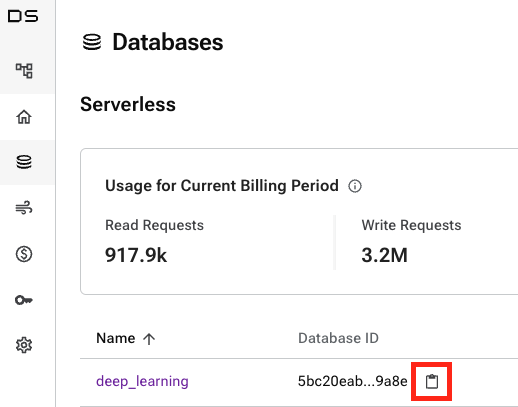

In [ ]:
from cassandra.concurrent import execute_concurrent_with_args
import cassio
cassio.init(
    database_id=input("database id copied above"), # Need to get database_id from the api_endpoint. It's the part after https:// and before the region. You can also get it above.
    token=token,
    keyspace="default_keyspace",  # this is optional
)
session = cassio.config.resolve_session()

# Fetching data asynchronously
rows = session.execute("SELECT key, query_vector_value FROM default_keyspace.addresses23") # Be sure the table name matches the name of your collection.

with open('embeddings.tsv', 'w') as embeddings_file, open('metadata.tsv', 'w') as metadata_file:
    for row in rows:
        address = row.key[1]
        vector = row.query_vector_value
        vector_as_tsv = '\t'.join(map(str, vector))
        embeddings_file.write(vector_as_tsv + '\n')
        metadata_file.write(address + '\n')

### Check out the embedding space. Pretty cool, huh?

To visualize in Tensorflow's embedding projector:

1. Go to the [Embedding Projector](https://projector.tensorflow.org/).
2. Click on "Load" to upload your `embeddings.tsv` file.
3. Upload the `metadata.tsv` file on the "Load" button next to the "Metadata" section.
4. You can now explore and visualize your embeddings.

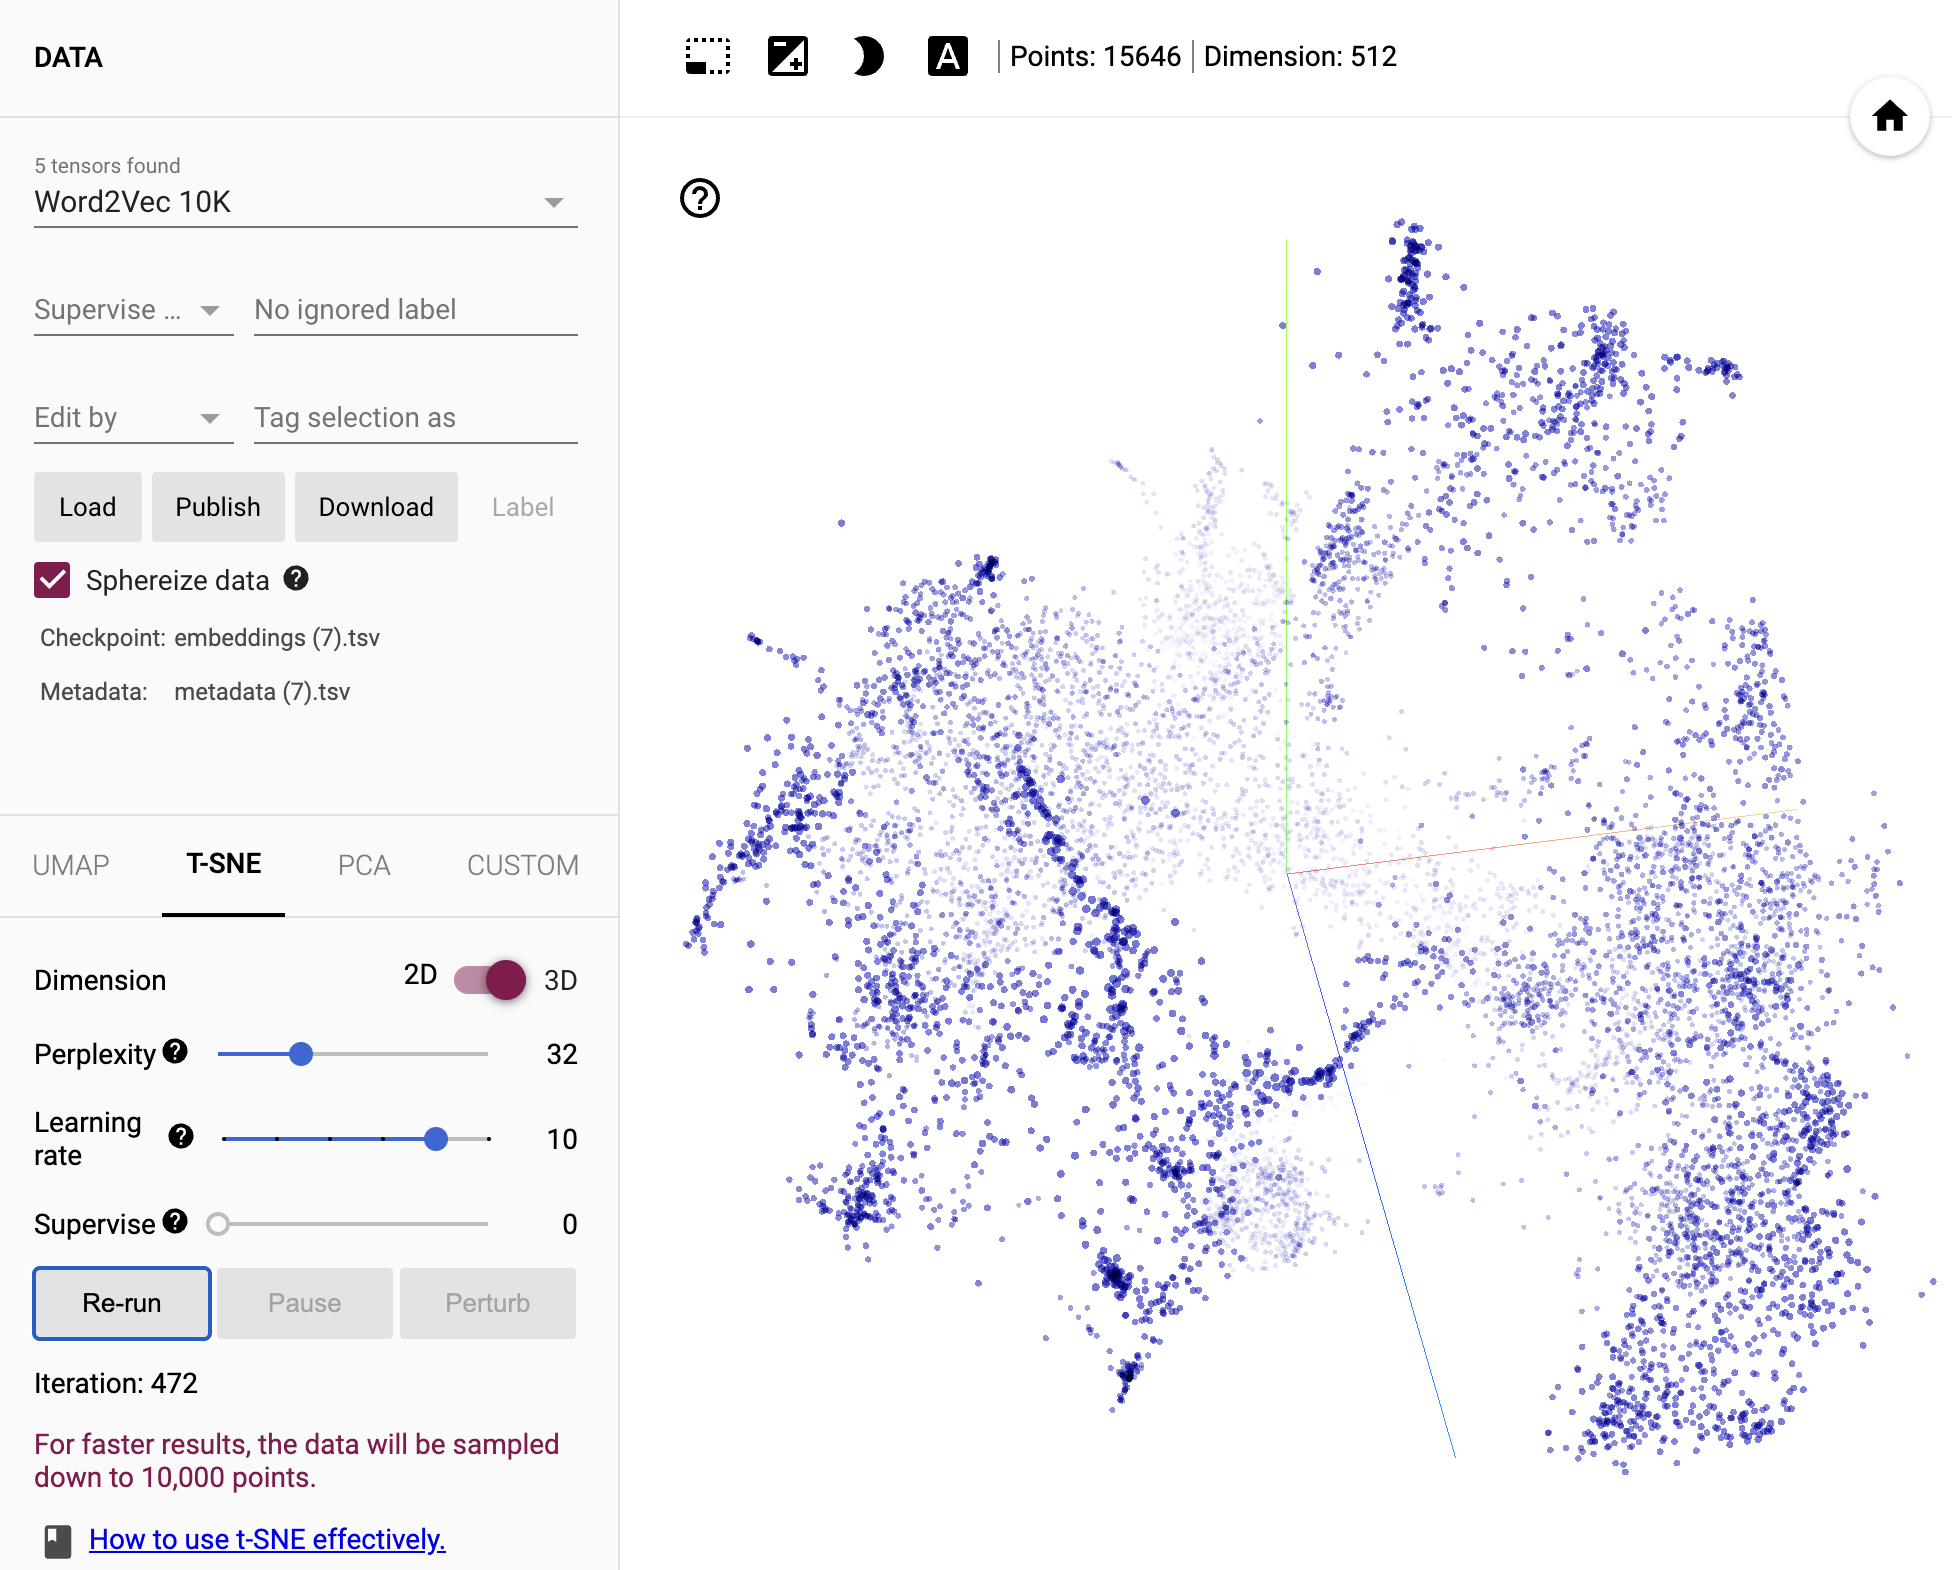

In [46]:
# Used at eval
from astrapy.db import AstraDB, AstraDBCollection

astrapy_db = AstraDB(
    token=token,
    api_endpoint=api_endpoint
)
mycollections = astrapy_db.get_collections()
if "addresses23" not in mycollections["status"]["collections"]:
    collection = astrapy_db.create_collection(collection_name="addresses23", dimension=vector_length)
else:
    collection = AstraDBCollection(collection_name="addresses23", astra_db=astrapy_db)

In [54]:
# Used at eval
address = "<number>1220W<number>H<street>EMSHOFF RD<street>,  <city>BELLVILLE<city>, <region>BX<region>, <postcode>77418<postcode>"
embedding = get_trained_embedding(address)
print(embedding)
results = collection.vector_find(
      vector=embedding,
      limit=5,
)
print(f"Corrupted Address: {address}")
print("Results:")
for result in results:
  print(f"Result: {result['_id']}")
  print(f"Similarity: {result['$similarity']}")

[-0.04941239207983017, 0.13971658051013947, -0.028224850073456764, -0.034157294780015945, -0.06703824549913406, 0.07644188404083252, -0.03319723159074783, 0.08738850802183151, -0.009384660050272942, 0.05150973051786423, -0.0361795499920845, 0.0725848525762558, 0.1464543342590332, -0.027587799355387688, -0.06665749102830887, 0.03288684040307999, 0.11531698703765869, 0.07362685352563858, 0.015133457258343697, -0.012898044660687447, 0.012720782309770584, 0.014783099293708801, -0.15530718863010406, 0.02414511702954769, 0.0007918266928754747, -0.09764928370714188, -0.04320333153009415, -0.004961048718541861, -0.020540250465273857, -0.12179625034332275, 0.062201593071222305, 0.024587636813521385, -0.06469608843326569, -0.06645725667476654, -0.0022795600816607475, -0.051198799163103104, -0.013366508297622204, 0.027933277189731598, 0.11740346997976303, 0.04903135076165199, 0.08472775667905807, -0.003898810828104615, 0.04114316403865814, -0.09836097061634064, 0.029398737475275993, -0.0227073039

In [48]:

success_score = 0
total = 0
for index, row in tqdm(val_pairs.iterrows(), total=val_pairs.shape[0]):
  true_address = row['ADDRESS']
  corrupted_addresses = row['CORRUPTED_ADDRESS']
  address_success_score = 0
  address_total = 0
  print(corrupted_addresses)
  break

  0%|          | 0/1570 [00:00<?, ?it/s]

<number>603</number> <street>SHADOW LAKEICT</street>,  <city>SEALY</city>,I<region>TX</region>n <postcode>77474</postcode>


In [49]:
# Let's see how the model performs on data in our validation set:
address_success_score = 0
address_total = 0
count = 0
for index, row in tqdm(val_pairs.iterrows(), total=val_pairs.shape[0]):
  true_address = row['ADDRESS']
  corrupted_address = row['CORRUPTED_ADDRESS']
  #print(f"Test address is: {corrupted_address}")
  embedding = get_trained_embedding(corrupted_address)
  results = collection.vector_find(
        vector=embedding,
        limit=1,
  )
  for predicted_address in results:
    #print(f"True result: {true_address}; Predicted result: {predicted_address['_id']}; Similarity: {predicted_address['$similarity']}")
    if (predicted_address['_id'] == true_address):
      address_success_score += 1
    address_total += 1
  count += 1
  # if count > 100:
  #   break
print(f"address_success_score is: {address_success_score}")
print(f"address_total is: {address_total}")

  0%|          | 0/1570 [00:00<?, ?it/s]

address_success_score is: 1082
address_total is: 1570


In [50]:
accuracy = address_success_score / address_total
print(f"Accuracy is: {accuracy}")

Accuracy is: 0.689171974522293


In [51]:
# Let's see how the model performs on data in our validation set:
address_success_score = 0
address_total = 0
for index, row in tqdm(val_pairs.iterrows(), total=val_pairs.shape[0]):
  true_address = row['ADDRESS']
  corrupted_address = row['CORRUPTED_ADDRESS']
  #print(f"Test address is: {corrupted_address}")
  embedding = get_trained_embedding(corrupted_address)
  results = collection.vector_find(
        vector=embedding,
        limit=3,
  )
  for predicted_address in results:
    #print(f"True result: {true_address}; Predicted result: {predicted_address['_id']}; Similarity: {predicted_address['$similarity']}")
    if (predicted_address['_id'] == true_address):
      address_success_score += 1
  address_total += 1
print(f"address_success_score is: {address_success_score}")
print(f"address_total is: {address_total}")

  0%|          | 0/1570 [00:00<?, ?it/s]

address_success_score is: 1270
address_total is: 1570


In [52]:
accuracy = address_success_score / address_total
print(f"Accuracy is: {accuracy}")

Accuracy is: 0.8089171974522293
